In [1]:
import random
import itertools
import numpy as np
import copy
import pandas as pd
from scipy.special import logsumexp

from matplotlib import pyplot as plt

from Python_Scripts import OrderedCategorySystem as OCS
from Python_Scripts import generate_plots as plots
from Python_Scripts import order_analyses as analyses
from Python_Scripts import RationalCategorySystem as RCS

In [2]:
F =  [12, 13, 15, 14, 16, 18, 17, 19, 20]
B =  [20, 19, 17, 18, 16, 14, 15, 13, 12]
M1 =  [16, 17, 15, 18, 14, 19, 13, 20, 12]
M2 = [16, 15, 17, 14, 18, 13, 19, 12, 20]

NEW = [i for i in range(9, 24)]
ALL = NEW + [1, 3, 29, 31]

SHIFT = 3
DISTRACTORS = [1, 3, 29, 31]

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]

item_space = [i for i in range(1, 32)]

### Load Participant Data

In [3]:
allParticipants = pd.read_csv('Results/participant_data.csv')
allParticipants =  allParticipants[(allParticipants['ATTEMPTS'] < 3) & (allParticipants['TOTAL_ERRORS'] < 4)]
participants = allParticipants['P_ID'].tolist()

participant_df = pd.read_csv('Results/trial_data.csv')    
participant_df = participant_df[participant_df['P_ID'].isin(participants)]

cat_assigns = ITEMS + ['I01', 'I03', 'I29', 'I31']
others = participant_df.columns.difference(cat_assigns)

trial_df = (
    participant_df[others]
      .assign(ITEMS = participant_df[cat_assigns].agg(
            lambda row: {k: v for k, v in row.items() if not pd.isna(v)},
            axis=1
        )
      )
)
participant_trials = list(trial_df.to_dict('index').values())

In [15]:
def generate_possible_sets(order, loc):
    distract_orders =  list(itertools.permutations(DISTRACTORS))
    if order in ['f', 'b', 'm']: # Sequence
        if order == 'f':
            item_orders = [F]
        elif order == 'b':
            item_orders = [B]
        else:
            item_orders = [M1, M2]
    possible_orders = []
    for i_ord in item_orders:
        for d_ord in distract_orders:
            if loc == 'L':
                loc_ord = [i-SHIFT for i in i_ord]
            elif loc == 'R':
                loc_ord = [i+SHIFT for i in i_ord]
            else:
                loc_ord = i_ord
            final_ord = loc_ord[0:1] + [d_ord[0]] + loc_ord[1:4] + [d_ord[1]] + loc_ord[4:5] + [d_ord[2]] + loc_ord[5:8] + [d_ord[3]]+ loc_ord[8:9]
            possible_orders.append(final_ord)
    return possible_orders

def generate_all_orderings():
    order_dic = {}
    for loc in ['L', 'C', 'R']:
        for order in ['f', 'b', 'm']:
            order_dic[f'{loc}{order}'] = generate_possible_sets(order, loc)

    return order_dic

def get_participant_loglike(data, temp, alpha=0.0):
    total_log_like = 0.0
    worst = 0.0
    best = 0.0
    for trial in data:
        log_likes = []
        for possible_order in trial:
            sys_scores_array = np.array([s for s, _ in possible_order[0]], dtype=np.float64)
            choice_indices = np.array([c for _, c in possible_order[0]], dtype=int)
            probs = OCS.softmax(sys_scores_array, temp)
            K = probs.shape[1] 
            uniform = 1.0 / K
            p_choice = ((1 - alpha) * probs[np.arange(probs.shape[0]), choice_indices]) + (alpha * uniform)
            log_like = np.sum(np.log(p_choice))
            log_likes.append(log_like)
        worst += np.min(log_likes)
        best += np.max(log_likes)
        total_log_like += logsumexp(log_likes) - np.log(len(log_likes))
    return total_log_like, best, worst

# Assumes you've precomputed participant system scores
def get_total_log_like(participants, temp, alpha=0.0):
    total_log_like = 0.0
    best_ll = 0.0
    worst_ll = 0.0
    for data in participants.values():
        marginal, best, worst = get_participant_loglike(data, temp, alpha)
        total_log_like += marginal
        best_ll += best
        worst_ll += worst
    return total_log_like, best_ll, worst_ll

def format_rcm_data(trial_data):
    rcmData = {t['P_ID']:[] for t in trial_data}
    for t in trial_data:
        item_assignments = {int(key[1:]): val for key, val in t['ITEMS'].items()}
        rcmData[t['P_ID']].append({'CHOICES': item_assignments, 'DEPTH': t['DEPTH'], 'LOC': t['LOC'], 'ORDER': t['ORDER'], 'STIMULI': t['STIMULI']})
    return rcmData

def get_trial_loglike(model, choices, possible_orders, item_space, alpha=0.0, uniform=None):
    likes = []
    for order in possible_orders:
        model_i = copy.deepcopy(model)
        log_like = 0
        for it in order:
            choice = choices[it]
            item_rep = item_space[it-1]
            if 0.0 < alpha < 1.0 and uniform is not None:
                prob_dist, choice_idx = model_i.get_item_likelihood(item_rep, choice)
                mixture = np.logaddexp(np.log(1 - alpha) + prob_dist[choice_idx], np.log(alpha) + np.log(uniform))
            elif alpha == 1.0 and uniform is not None:
                mixture = np.log(uniform)
            else:
                prob_dist, choice_idx = model_i.get_item_likelihood(item_rep, choice)
                mixture =  prob_dist[choice_idx]
            log_like += mixture
        likes.append(log_like)
    avg_like = logsumexp(likes) - np.log(len(likes))
    best_like = np.max(likes)
    worst_like = np.min(likes)
    return avg_like, best_like, worst_like

def get_participant_loglike_rcm(data, order_dic, item_space, c=0.5, alpha=0.0, diff3=False):
    avg_ll = 0.0
    worst_ll = 0.0
    best_ll = 0.0
    existing_items = [item_space[i] for i in [1, 2, 3, 5, 6, 7, 23, 24, 25, 27, 28, 29]]
    mu_0 = [np.mean(item_space)]
    var_0 = [np.var(item_space)]
    for trial in data:
        d, l, o = trial['DEPTH'], trial['LOC'], trial['ORDER']
        orders = order_dic[f'{l}{o}']
        choices = trial['CHOICES']
        if diff3 and d == 3:
            syst = ['AA', 'AA', 'AA', 'AB', 'AB', 'AB', 'BA', 'BA', 'BA', 'BB', 'BB', 'BB']
            max_new = 3
            uniform = 1/7
        else:
            syst = ['A' , 'A' , 'A' , 'A' , 'A' , 'A' , 'B' , 'B' , 'B' , 'B' , 'B' , 'B' ]
            max_new = 1
            uniform = 1/3
            if d == 3:
                choices = {key: val[0] for key, val in choices.items()}
        rcm = RCS.RationalModel(c, mu_0, var_0,  np.array([1.0]),  np.array([1.0]), partition=syst, stimuli=existing_items, max_new_clusters=max_new)
        avg, best, worst = get_trial_loglike(rcm, choices, orders, item_space, alpha, uniform)
        avg_ll += avg
        best_ll += best
        worst_ll += worst
    return avg_ll, best_ll, worst_ll

def get_total_log_like_rcm(trial_data, order_dic, item_space, c=0.5, alpha=0.0, diff3=False):
    avg_ll, best_ll, worst_ll = 0.0, 0.0, 0.0
    for _, p_data in trial_data.items():
        avg, best, worst = get_participant_loglike_rcm(p_data, order_dic, item_space, c, alpha, diff3)
        avg_ll += avg
        best_ll += best
        worst_ll += worst
    return avg_ll, best_ll, worst_ll

In [5]:
random.seed(13)
np.random.seed(13)

ordered_trials = [t for t in participant_trials if t['ORDER'] != 'a']
order_dic = generate_all_orderings()
allData, D, lookupTree = OCS.compute_possible_scores(ordered_trials, order_dic, item_space)

In [6]:
'''
2 Level: Partition = [A, A, A, A, A, A, B, B, B, B, B, B]
3 Level: Partition = [AA, AA, AA, AB, AB, AB, BA, BA, BA, BB, BB, BB]
'''

item_values = (np.array(item_space) - min(item_space)) / (max(item_space) - min(item_space))
item_values = [np.array([val]) for val in item_values.tolist()]

data_rcm = format_rcm_data(ordered_trials)
avg, best, worst = get_total_log_like_rcm(data_rcm, order_dic, item_values, 0.3, alpha=0.0, diff3=True)
print(avg, best, worst)

-7360.0986692199895 -7292.635565804591 -7429.030087089828


In [7]:
error_rate = np.mean([e['ERRORS']/4 for e in ordered_trials])
num2 = len([t for t in ordered_trials if t['DEPTH'] == 2])
num3 = len(ordered_trials) - num2
# for 2 level 
er2 = (3/2)*error_rate
# for 3 level
er3 = (7/4)*error_rate

print(f'Avg errors = {round(((er2*num2) + (er3)*num3)/len(ordered_trials), 2)}')

Avg errors = 0.07


1.7000000000000002


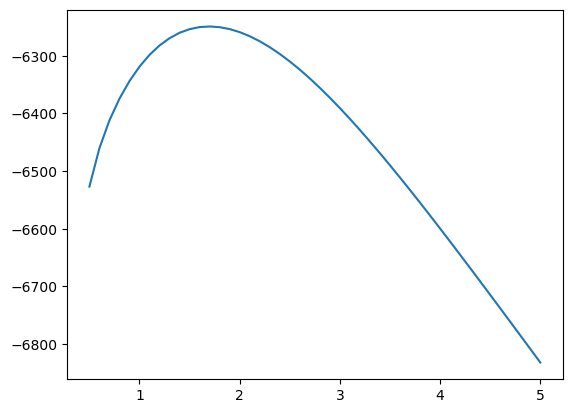

In [16]:
temps = np.linspace(0.5, 5, 46)
likes = [get_total_log_like(allData, t, 0.07) for t in temps]
likes = [l[0] for l in likes]
plt.plot(temps, likes)
print(temps[np.argmax(likes)])

In [17]:
model_likelihood = get_total_log_like(allData, 1.7, 0.07)
print(model_likelihood)

(-6249.284810760024, -5928.913215735292, -6770.798666967512)


0.15


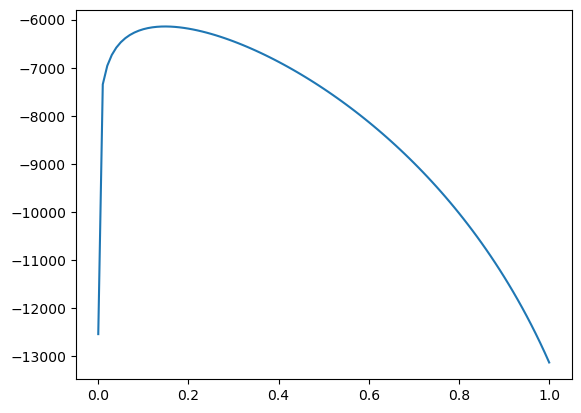

In [18]:
alphas = np.linspace(0, 1, 101)
likes = [get_total_log_like(allData, 1, a) for a in alphas]
likes = [l[0] for l in likes]
plt.plot(alphas, likes)
print(alphas[np.argmax(likes)])

In [19]:
model_likelihood = get_total_log_like(allData, 1.0, 0.15)
print(model_likelihood)

(-6141.517977824123, -5837.3325472017, -6669.922562094359)


In [20]:
alphas = np.linspace(0, 0.4, 41)
temps = np.linspace(1.0, 5, 41)

### Random assignment

In [21]:
num_3 = len([t for t in ordered_trials if t['DEPTH'] == 3])
num_2 = len([t for t in ordered_trials if t['DEPTH'] == 2])
 
random_2level = np.log(1/3)*13 # categorizing 4 distractors + 9 novel stimuli
random_3level = np.log(1/7)*13
random_likelihood = (random_2level*num_2) + (random_3level*num_3)
print(random_likelihood)

-13125.876881461609


In [22]:
# only 2 level focus
stats = analyses.get_level2_cat_stats(participant_df, ITEMS)

num_A = stats['NUM_A'].sum()
num_B = stats['NUM_B'].sum()
num_X = stats['NUM_X'].sum()

random = np.log((1/7))*num_X + np.log((3/7))*num_A + np.log((3/7))*num_B
print(random)

-9150.358526289758
